<a href="https://colab.research.google.com/github/Joeyearim/hello_/blob/main/AI_14_4TH_%EC%A1%B0%EC%98%88%EB%A6%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM을 통한 트위터 감정 분석**

## LSTM을 사용하여 트위터 트윗 데이터 속 내포되어 있는 감정을 분석(nlp)해 유추 할 수 있는 모델을 만들고자 하였습니다.

In [1]:
# 사용할 패키지들을 임포트 합니다.

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
#추가적인 임포트를 진행합니다.

from wordcloud import STOPWORDS 
from wordcloud import WordCloud
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import one_hot
from nltk.stem import PorterStemmer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout
from keras.models import Sequential

In [2]:
# 사용하고자 하는 데이터를 임포트 합니다. 해당 데이터는 캐글 사이트를 통해 가져왔습니다.


from google.colab import files
train_df = files.upload()
test_df = files.upload()
val_df = files.upload()

Saving train.txt to train.txt


Saving test.txt to test.txt


Saving val.txt to val.txt


In [21]:
#코랩 환경에서 진행하다보니, pd.read_csv를 통해 데이터를 불러왔습니다.
#데이터가 :를 통해 나누어지고, 컬럼 네임이 따로 없어 컬럼 이름을 붙여준 후 utf-8 타입으로 불러옵니다.


train_df=pd.read_csv('train.txt', delimiter=';', names=["Comment","Emotion"], encoding="utf-8")
test_df=pd.read_csv('test.txt', delimiter=';', names=["Comment","Emotion"], encoding="utf-8")
val_df=pd.read_csv('val.txt', delimiter=';', names=["Comment","Emotion"], encoding="utf-8")

In [22]:
#shape을 살펴보면 다음과 같은 행렬을 지니고 있습니다.

print("Train : ", train_df.shape)
print("Test : ", test_df.shape)
print("Validation : ", val_df.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [23]:
#데이터 셋의 구조는 이러합니다.

train_df[:5]

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [24]:
#또한 감정 컬럼의 경우 아래와 같은 감정 유니크 값을 가지고 있습니다.

emotions_list = train_df['Emotion'].unique()
emotions_list


array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [25]:
# 불용어를 지정해주겠습니다. 불용어는 감정 분석에 큰 영향을 주지 않는 단어들입니다.

comment_words = '' 
stopwords = set(STOPWORDS)

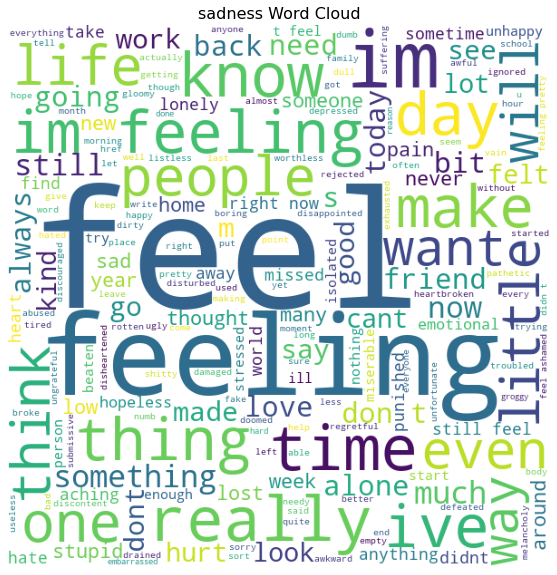

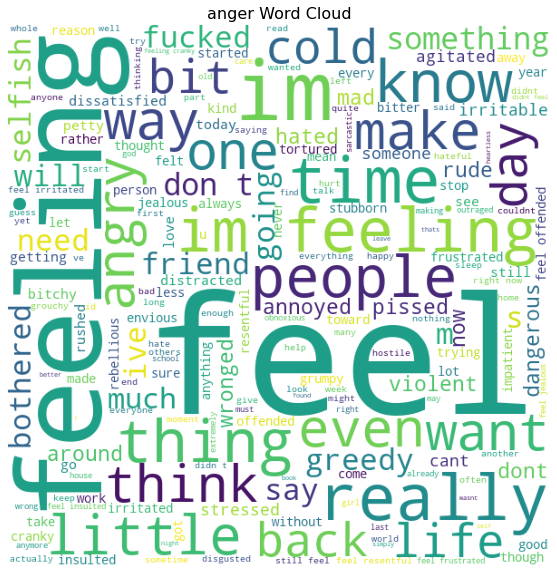

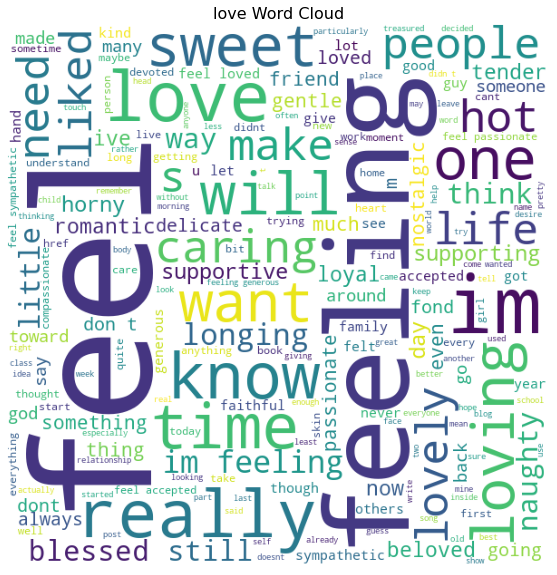

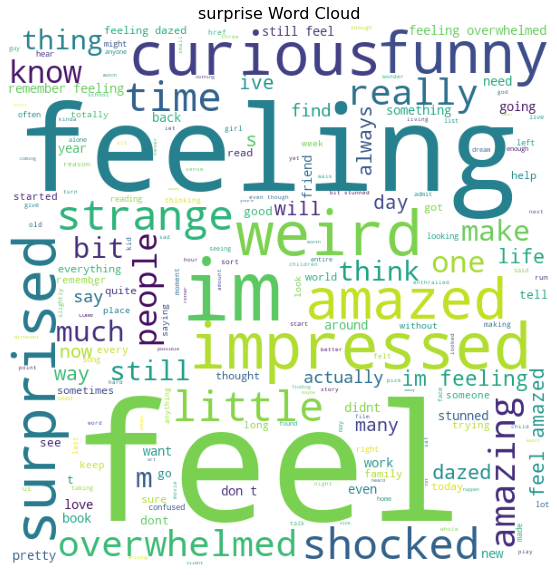

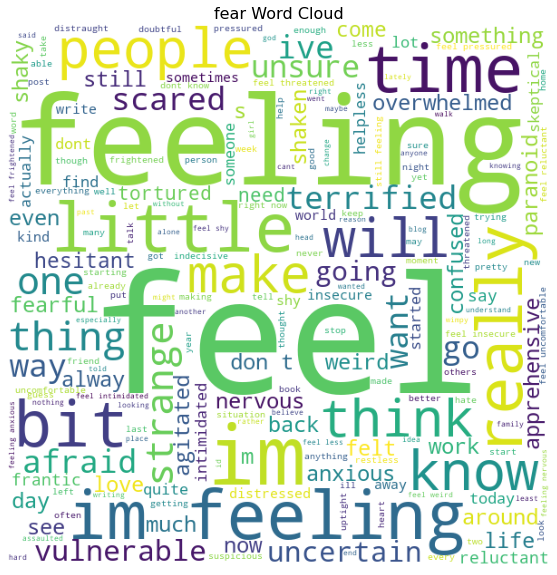

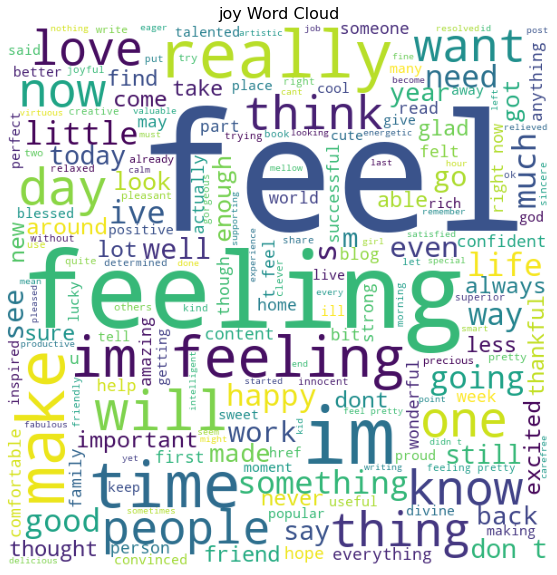

In [26]:
# 데이터 속 단에들에 대한 wordcloud를 만들어보려 합니다.

def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");


for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_df.loc[train_df['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600,background_color ='white', 
                stopwords = stopwords).generate(text)
    words_cloud(wordcloud, emotion)

In [27]:
# 문장의 길이도 세보았습니다. 
train_df['length'] = [len(x) for x in train_df['Comment']]
train_df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


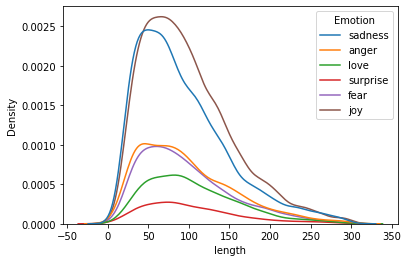

In [28]:
#감정 컬럼과 커멘드 컬럼의 길이의 상관관계를 나타내는 그래프입니다.
#50~150 길이의 타이핑 문장일 수록 감정이 잘 드러나는 것을 볼 수 있습니다. 
#트위터 상에는 즐거움과 슬픔의 감정의 비중이 많은 것 또한 확인 가능합니다.

sns.kdeplot(x=train_df["length"], hue=train_df["Emotion"])

In [29]:
# 모델이 정확한 수행을 할 수 있도록 라벨 인코더를 이용해서 감정 컬럼에 있는 문자들을 0부터 시작하는 정수형 숫자로 바꿔주었습니다.

lb = LabelEncoder()
train_df['Emotion'] = lb.fit_transform(train_df['Emotion'])
test_df['Emotion'] = lb.fit_transform(test_df['Emotion'])
val_df['Emotion'] = lb.fit_transform(val_df['Emotion'])

In [30]:
#아래와 같이 인코딩 된 것을 볼 수 있습니다.
train_df.head(6)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
5,ive been feeling a little burdened lately wasn...,4,65


In [31]:
#데이터 정제
#text_cleaning 함수를 이용해서 관계 없는 문장 부호들이나 스트링 그리고 패딩 등을 제거해줍니다.

def text_cleaning(df, column):
    """관계없는 문자, 스트링 및 패딩 제거"""
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [32]:
# 문장의 최소,최고 길이를 확인하고 vocabSize 사이즈를 설정합니다.

max_len = train_df['length'].max()
min_len = train_df["length"].min()

vocabSize = 11000


In [33]:
#모델링을 하기 위해 데이터 정제를 적용하고 범주화 처리를 진행합니다.

x_train = text_cleaning(train_df, "Comment")
x_test = text_cleaning(test_df, "Comment")
x_val = text_cleaning(val_df, "Comment")


y_train = train_df["Emotion"]
y_test = test_df["Emotion"]
y_val = val_df["Emotion"]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


(16000, 300)
(2000, 300)
(2000, 300)


In [34]:
#모델을 학습합니다. 

#Embedding() : Embedding()은 단어를 밀집 벡터로 만드는 역할을 합니다. 
#인공 신경망 용어로는 임베딩 층(embedding layer)을 만드는 역할을 합니다. Embedding()은 정수 인코딩이 된 단어들을 입력을 받아서 임베딩을 수행합니다.
#input_dim : 입력 뉴런의 수를 설정합니다.
#input_length = 입력 시퀀스의 길이

#LSTM은 RNN의 특별한 한 종류로, 긴 의존 기간의 문제를 피하기 위해 명시적으로(explicitly) 설계(긴 시간 동안의 정보를 기억하는 것은 모델의 기본적인 행동)


model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [35]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1650000   
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [36]:
hist = model.fit(x_train,y_train,epochs=25,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1)
#verbose가 있으면 함수 수행시 발생하는 상세한 정보들을 표준 출력으로 자세히 내보낼 것인가를 나타냅니다. 보통 0 은 출력하지 않고, 1은 자세히, 2는 함축적인 정보만 출력하는 형태로 되어 있습니다.

Epoch 1/25
250/250 [==============================] - 13s 22ms/step - loss: 1.4157 - accuracy: 0.4586 - val_loss: 0.9387 - val_accuracy: 0.7145
Epoch 2/25
250/250 [==============================] - 5s 20ms/step - loss: 0.5560 - accuracy: 0.8266 - val_loss: 0.3673 - val_accuracy: 0.8830
Epoch 3/25
250/250 [==============================] - 5s 20ms/step - loss: 0.2656 - accuracy: 0.9153 - val_loss: 0.3288 - val_accuracy: 0.8900
Epoch 4/25
250/250 [==============================] - 5s 20ms/step - loss: 0.1882 - accuracy: 0.9382 - val_loss: 0.3308 - val_accuracy: 0.8880
Epoch 5/25
250/250 [==============================] - 5s 20ms/step - loss: 0.1491 - accuracy: 0.9506 - val_loss: 0.3290 - val_accuracy: 0.8890
Epoch 6/25
250/250 [==============================] - 5s 20ms/step - loss: 0.1266 - accuracy: 0.9562 - val_loss: 0.3561 - val_accuracy: 0.8835
Epoch 7/25
250/250 [==============================] - 5s 20ms/step - loss: 0.1054 - accuracy: 0.9636 - val_loss: 0.3740 - val_accuracy: 0.888

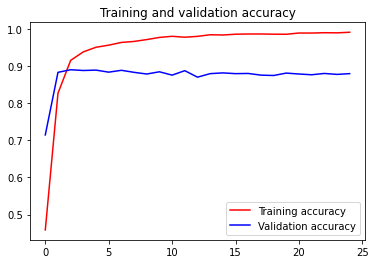

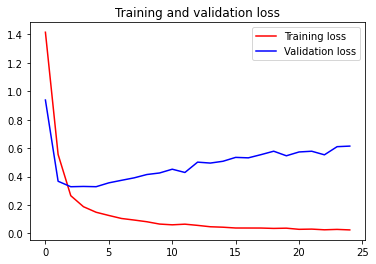

In [39]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']

"""
- acc: 매 epoch 마다의 훈련 정확도

- loss: 매 epoch 마다의 훈련 손실 값

- val_acc: 매 epoch 마다의 검증 정확도

- val_loss: 매 epoch 마다의 검증 손실 값
"""


epochs=range(len(acc))


# 모델 검증 정확도와 모델 검증 손실도 확인하기


plt.plot(epochs,acc,'r', label='Training accuracy')
plt.plot(epochs,val_acc,'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r', label='Training loss')
plt.plot(epochs,val_loss,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
# 모델이 잘 학습했는지 확인하기
# 영어 자연어처리를 위한 전처리 과정에서는 동사의 어간을 추출하기 위한 'stemming' 함수

def sentence_cleaning(sentence):
    """Pre-processing sentence for prediction"""
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    return pad

In [41]:
#예제 적용

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
joy : 0.9980144500732422


Your point on this certain matter made me outrageous, how can you say so? This is insane.
anger : 0.998422384262085


I can't do it, I'm not ready to lose anything, just leave me alone
sadness : 0.9918745160102844


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
joy : 0.9999171495437622


